# Regularization

Regularization is a umbrella term that refers to approaches that help reduce the chance of overfitting, usually either by normalization or through added penatlies.

# Bias–Variance Tradeoff

The **bias–variance tradeoff** is a fundamental concept in machine learning that explains the sources of error in predictive models.  

## 1. Total Error Decomposition

For a model prediction \(\hat{f}(x)\) of the true function \(f(x)\):

$$ 
\mathbb{E}\left[(y - \hat{f}(x))^2\right] 
= \underbrace{(\text{Bias}[\hat{f}(x)])^2}_{\text{Systematic error}}
+ \underbrace{\text{Var}[\hat{f}(x)]}_{\text{Model sensitivity}}
+ \underbrace{\sigma^2}_{\text{Irreducible error}}
$$


- **Bias**: Error from incorrect assumptions in the model (underfitting).  
- **Variance**: Error from sensitivity to small fluctuations in the training set (overfitting).  
- **Irreducible error (\(\sigma^2\))**: Noise in the data that no model can remove.

## 2. Bias vs. Variance

| Aspect | High Bias (Underfitting) | High Variance (Overfitting) |
|--------|--------------------------|------------------------------|
| Model complexity | Too simple | Too complex |
| Training error | High | Low |
| Test error | High | High |
| Example | Linear model on non-linear data | Deep tree without pruning |

## 3. The Tradeoff

- Increasing **model complexity** → Bias decreases, Variance increases.  
- Decreasing **model complexity** → Bias increases, Variance decreases.  

The goal is to find the **sweet spot** (optimal complexity) where **test error is minimized**.

## 4. Key Teaching Insight

- **Bias** = "How far are we from the truth on average?"  
- **Variance** = "How much do we wiggle around that truth if we retrain on new data?"  
- Good models balance both: **not too simple, not too complex**.

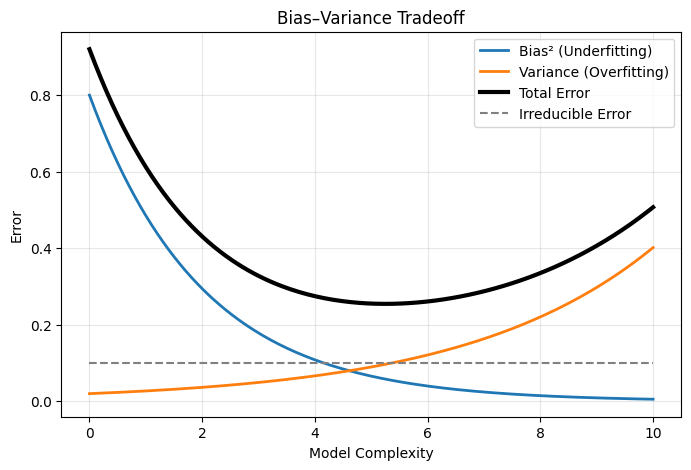

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Model complexity axis
complexity = np.linspace(0, 10, 200)

# Hypothetical curves
bias2 = np.exp(-0.5 * complexity) * 0.8   # squared bias
variance = np.exp(0.3 * complexity) / 50  # variance
irreducible = 0.1 * np.ones_like(complexity)

total_error = bias2 + variance + irreducible

# Plot
plt.figure(figsize=(8,5))
plt.plot(complexity, bias2, label="Bias² (Underfitting)", linewidth=2)
plt.plot(complexity, variance, label="Variance (Overfitting)", linewidth=2)
plt.plot(complexity, total_error, label="Total Error", color="black", linewidth=3)
plt.plot(complexity, irreducible, "--", label="Irreducible Error", color="gray")

plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.title("Bias–Variance Tradeoff")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 1. Ridge regression ($L_2$ regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 

$$ J(\theta) =  \frac{1}{2}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda\sum_{j=1}^n \boldsymbol{\theta}_j^2$$

where $\lambda$ is a free parameter that controls the strength of the penalty.

### 2. Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:

$$ J(\theta) = \frac{1}{2}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2+ \lambda\sum_{j=1}^n |\theta_j|$$

Though this is conceptually very similar to ridge regression, the results can differ surprisingly: that is, lasso regression can set certain features to zero, while ridge regression focuses on shrinking all parameters so it is not overly reliant on one feature.

### 3. Elastic net 

When you lack domain knowledge, you can simply use elastic net.

$$
J(\theta) = \frac{1}{2}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^n |\theta_j| + (1 - \lambda) \sum_{k=1}^n \theta_k^2
$$



### Ridge or Lasso or Elastic net??

Regularization should be ALMOST ALWAYS used, since these techniques reduces overfitting.

How to choose is a little bit difficult. It is easier to understand the assumptions behind.
1.  Ridge assumes that coefficients are normally distributed.   **Thus, if you don't want any feature to dominate too much, use Ridge.**
2. Lasso assumes that coefficients are Laplace distributed (in layman sense, it mean some predictors are very useful while some are completely irrelevant).   Here, Lasso has the ability to shrink coefficient to zero thus eliminate predictors that are not useful to the output, thus automatic feature selection.  **In simple words, if you have only very few predictors with medium/large effect, use Lasso.**
3.  Elastic basically is a compromise between the two, and thus take huge computation time to reach that compromise.  **If you have the resource to spare, you can use Elastic net**


## Code

In [1]:
#experiment tracking
import mlflow
import os
# This the dockerized method.
# We build two docker containers, one for python/jupyter and another for mlflow.
# The url `mlflow` is resolved into another container within the same composer.
mlflow.set_tracking_uri("http://localhost:5000")
# In the dockerized way, the user who runs this code will be `root`.
# The MLflow will also log the run user_id as `root`.
# To change that, we need to set this environ["LOGNAME"] to your name.
os.environ["LOGNAME"] = "chaky"
# mlflow.create_experiment(name="chaky-diabetes-example")  #create if you haven't create
mlflow.set_experiment(experiment_name="chaky-regularization-example")

<Experiment: artifact_location='mlflow-artifacts:/218838100027711537', creation_time=1693278210177, experiment_id='218838100027711537', last_update_time=1693278210177, lifecycle_stage='active', name='chaky-regularization-example', tags={}>

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from time import time

diabetes = load_diabetes()
print("Features: ", diabetes.feature_names)
X = diabetes.data
y = diabetes.target
m = X.shape[0]  #number of samples
n = X.shape[1]  #number of features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# actually you can do like this too
# X = np.insert(X, 0, 1, axis=1)
intercept = np.ones((X_train.shape[0], 1))
X_train   = np.concatenate((intercept, X_train), axis=1)
intercept = np.ones((X_test.shape[0], 1))
X_test    = np.concatenate((intercept, X_test), axis=1)

Features:  ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In [3]:
from sklearn.model_selection import KFold

class LinearRegression(object):
    
    #in this class, we add cross validation as well for some spicy code....
    kfold = KFold(n_splits=3)
            
    def __init__(self, regularization, lr=0.001, method='batch', num_epochs=500, batch_size=50, cv=kfold):
        self.lr         = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method     = method
        self.cv         = cv
        self.regularization = regularization

    def mse(self, ytrue, ypred):
        return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]
    
    def fit(self, X_train, y_train):
            
        #create a list of kfold scores
        self.kfold_scores = list()
        
        #reset val loss
        self.val_loss_old = np.infty

        #kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]
            
            self.theta = np.zeros(X_cross_train.shape[1])
            
            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            
            #one epoch will exhaust the WHOLE training set
            with mlflow.start_run(run_name=f"Fold-{fold}", nested=True):
                
                params = {"method": self.method, "lr": self.lr, "reg": type(self).__name__}
                mlflow.log_params(params=params)
                
                for epoch in range(self.num_epochs):
                
                    #with replacement or no replacement
                    #with replacement means just randomize
                    #with no replacement means 0:50, 51:100, 101:150, ......300:323
                    #shuffle your index
                    perm = np.random.permutation(X_cross_train.shape[0])
                            
                    X_cross_train = X_cross_train[perm]
                    y_cross_train = y_cross_train[perm]
                    
                    if self.method == 'sto':
                        for batch_idx in range(X_cross_train.shape[0]):
                            X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                            y_method_train = y_cross_train[batch_idx] 
                            train_loss = self._train(X_method_train, y_method_train)
                    elif self.method == 'mini':
                        for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                            #batch_idx = 0, 50, 100, 150
                            X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                            y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                            train_loss = self._train(X_method_train, y_method_train)
                    else:
                        X_method_train = X_cross_train
                        y_method_train = y_cross_train
                        train_loss = self._train(X_method_train, y_method_train)

                    mlflow.log_metric(key="train_loss", value=train_loss, step=epoch)

                    yhat_val = self.predict(X_cross_val)
                    val_loss_new = self.mse(y_cross_val, yhat_val)
                    mlflow.log_metric(key="val_loss", value=val_loss_new, step=epoch)
                    
                    #early stopping
                    if np.allclose(val_loss_new, self.val_loss_old):
                        break
                    self.val_loss_old = val_loss_new
            
                self.kfold_scores.append(val_loss_new)
                print(f"Fold {fold}: {val_loss_new}")
            
                    
    def _train(self, X, y):
        yhat = self.predict(X)
        m    = X.shape[0]        
        grad = (1/m) * X.T @(yhat - y) + self.regularization.derivation(self.theta)
        self.theta = self.theta - self.lr * grad
        return self.mse(y, yhat)
    
    def predict(self, X):
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercept
                               #w1....wn are the weights / coefficients / theta
    def _bias(self):
        return self.theta[0]

Now we can create `Ridge`, `Lasso` and `Elastic` class that extends the `LinearRegression`, with added penalty.

In [4]:
class LassoPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta)
    
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
        
    def derivation(self, theta):
        return self.l * 2 * theta
    
class ElasticPenalty:
    
    def __init__(self, l = 0.1, l_ratio = 0.5):
        self.l = l 
        self.l_ratio = l_ratio

    def __call__(self, theta):  #__call__ allows us to call class as method
        l1_contribution = self.l_ratio * self.l * np.sum(np.abs(theta))
        l2_contribution = (1 - self.l_ratio) * self.l * 0.5 * np.sum(np.square(theta))
        return (l1_contribution + l2_contribution)

    def derivation(self, theta):
        l1_derivation = self.l * self.l_ratio * np.sign(theta)
        l2_derivation = self.l * (1 - self.l_ratio) * theta
        return (l1_derivation + l2_derivation)
    
class Lasso(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = LassoPenalty(l)
        super().__init__(self.regularization, lr, method)
        
class Ridge(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = RidgePenalty(l)
        super().__init__(self.regularization, lr, method)
        
class ElasticNet(LinearRegression):
    
    def __init__(self, method, lr, l, l_ratio=0.5):
        self.regularization = ElasticPenalty(l, l_ratio)
        super().__init__(self.regularization, lr, method)


## Experiment

In [5]:
#helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [6]:
regs = ["Ridge", "Lasso", "ElasticNet"]

for reg in regs:

    params = {"method": "batch", "lr": 0.1, "l": 0.1}
    mlflow.start_run(run_name=f"method-{params['method']}-lr-{params['lr']}-reg-{reg}", nested=True)
    
    print("="*5, reg, "="*5)

    # #######
    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
    model = type_of_regression(**params)  
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    mse  = model.mse(y_test, yhat)

    print("Test MSE: ", mse)
    mlflow.log_metric(key="test_mse", value=mse)

    signature = mlflow.models.infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # #######

    mlflow.end_run()

===== Ridge =====
Fold 0: 5019.957764397
Fold 1: 3789.7283075525406
Fold 2: 3231.9871784874213
Test MSE:  3952.505584097506


/Users/chaklam/Github/Machine-Learning/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== Lasso =====
Fold 0: 3473.727565365972
Fold 1: 3417.382642134025
Fold 2: 3204.376603720075
Test MSE:  2914.256969310874
===== ElasticNet =====
Fold 0: 3784.5882498239384
Fold 1: 3384.868051931774
Fold 2: 3064.9560116605444
Test MSE:  3065.0966947039674


## Group Workshop - Check your understandings

| | Egg price | Gold price    | Oil price   | GDP   | $\hat{y}$ |  $(\hat{y} - y)^2$ |
|---:|:------ |:-----------   |:------      |:------|:------    |  :------           |    
| 1  | 3      | 100           | 4           | 21    | 28        |  49                |
| 2  | 4      | 500           | 7           | 43    | 79        |  1296              |
| 3  | 5      | 200           | 6           | 56    | 48        |  64                |
| 4  | 6      | 300           | 8           | 21    | 66        |  2025              |
| 5  | 7      | 400           | 2           | 44    | 60        |  256               |

Note:  this table is filled with given weight of [2, 0.1, 3].

Answer the following questions:

Instruction:  Gather in your group.  Will randomly pick groups to present.

1.  Explain regularization in your own words.
2.  For `LassoPenalty`, show by hand why the derivation is `self.l * np.sign(theta)`
3.  For `RidgePenalty`, show by hand why the derivation is `self.l * 2 * theta`
4.  Using mini-batch gradient descent based on $(\mathbf{x}^{(2)}, \mathbf{x}^{(4)}, \mathbf{x}^{(5)})$, and using **Ridge regression**, what is $J(\theta)$?  Assume $\lambda = 0.1$
5.  Continued from above, what is $\displaystyle \frac{\partial J}{\partial \theta_2}$
6.  Continued from above, what is $\displaystyle \frac{\partial J}{\partial \theta}$
7.  What would be the new theta?
8.  Performed 4,5,6 with **Lasso Regression**.  Assume $\lambda = 0.1$
9.  What does `LinearRegression` inside `Ridge(LinearRegression)` mean?
10. What does `str_to_class` function do?
11. Based on everything you have done in this workshop, what do you think is a good way to decide when to use Ridge, Lasso, or Elastic regression.